<a href="https://colab.research.google.com/github/bitmos/Deep_Learning/blob/main/Potato_Disease_Predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [ ]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=50

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataset=tf.keras.preprocessing.image_dataset_from_directory("/content/drive/MyDrive/PlantVillage",
                                                   shuffle=True,
                                                   image_size=(IMAGE_SIZE,IMAGE_SIZE),
                                                    batch_size=BATCH_SIZE
                                                   )

Found 2152 files belonging to 3 classes.


In [ ]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [ ]:
len(dataset)

68

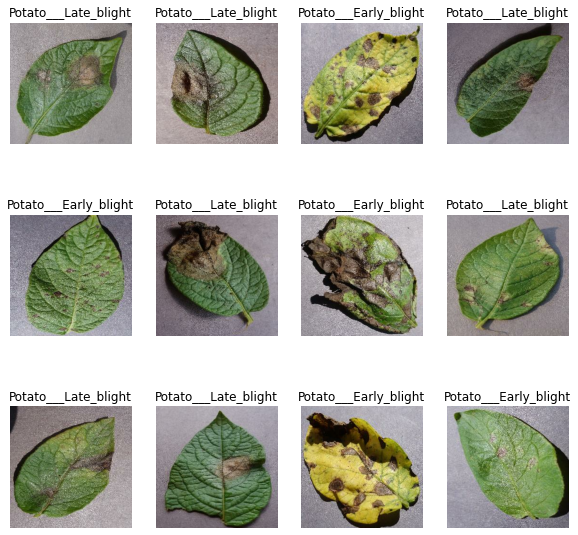

In [ ]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
           for i in range(12):
                plt.subplot(3,4,i+1)
                plt.imshow(image_batch[i].numpy().astype("uint8"))
                plt.title(class_names[label_batch[i]])
                plt.axis("off")

In [ ]:
len(dataset)

68

In [ ]:
train_size=0.8
len(dataset)*train_size

54.400000000000006

In [ ]:
train_ds=dataset.take(54)
len(train_ds)

54

In [ ]:
test_ds=dataset.skip(54)
len(test_ds)

14

In [ ]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [ ]:
val_ds=test_ds.take(6)
len(val_ds)

6

In [ ]:
test_ds=test_ds.skip(6)
len(test_ds)

8

In [ ]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    ds_size=len(ds)
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    return train_ds,val_ds,test_ds

In [ ]:
train_ds,val_ds,test_ds=get_dataset_partitions_tf(dataset)

In [ ]:
len(train_ds)

54

In [ ]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [ ]:
data_augmentation=tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

In [ ]:
input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes=3
model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPool2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax'),
    
])
model.build(input_shape=input_shape)

In [ ]:
model.compile(
optimizer='adam',
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
metrics=['accuracy']
)

In [ ]:
model.fit(
train_ds,
epochs=EPOCHS,
batch_size=BATCH_SIZE,
verbose=1,
validation_data=val_ds
    
)


Epoch 1/50


UnimplementedError: ignored

In [ ]:
model.evaluate(test_ds)

In [ ]:
import numpy as np
for images_batch,labels_batch in test_ds.take(1):
  first_image=image_batch[0].numpy().astype('uint8')
  first_label=label_batch[0].numpy()
  print("First Image to predict")
  plt.imshow(first_image)
  print("Actual Label:",class_names[first_label])
  batch_prediction=model.predict(images_batch)
  print("Predicted LAbel:1",class_names[np.argmax(batch_prediction[0])])

In [ ]:
def Predict(model,img):
  img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array=tf.expand_dims(img_array,0)
  predictions=model.predict(img_array)
  predicted_class=class_names[np.argmax(predictions[0])]
  confidence=round(100*(np.max(predictions[0])),2)
  return predicted_class,confidence

In [ ]:
plt.figure(figsize=(15,15))
for images,labels in test_ds.take(1):
  for i in range(9):
     plt.subplot(3,3,i+1)
     plt.imshow(images[i].numpy().astype("uint8"))
     predicted_class,confidence= Predict(model,images[i].numpy())
     actual_class=class_names[labels[i]]
     plt.title(f"Actual:{actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}")

     plt.axis("off")

In [ ]:
model_version=1
model.save('/content/drive/MyDrive/Saved_models/')

In [ ]:
tensorflowjs_converter --input_format keras \
                       path/to/my_model.h5 \
                       path/to/tfjs_target_dir

In [ ]:
tf.keras.models.load_model('/content/drive/MyDrive/Saved_models/')